# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, stats


from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import sys
import multiprocessing as mp

from Bio import SeqIO, SeqUtils
import math
import time

In [3]:
sys.path.append("./mean_field_electrostatics/v2/")
import base_classes
import morbidelli as m
import hubbuch as h
import hsu
import misc_functions as misc

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

# FASTA sequences

In [4]:
records = {}
i = 0
for r in SeqIO.parse("/home/chase/my_work/misc/databases/uniprot_reviewed.fasta", "fasta"):
    if 'X' not in r.seq and 'Z' not in r.seq and 'B' not in r.seq and 'J' not in r.seq: # remove records with sequence ambiguity
        records[i] = r
        i += 1

# Hsu model (more general version of Morbidelli model)

## Development example

In [4]:
def residual(ion_str, kprime_target, dpr, seq, pH, surf_area, porosity, surf_dens, res_bc_charge, res_bc_potential, pro_bc_charge, pro_bc_potential):
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    
    res = hsu.resin(sol, 'sulfonate', surf_dens=surf_dens, dpr=dpr, bc_charge=res_bc_charge, bc_potential=res_bc_potential)
    pro = hsu.protein(sol, seq=seq, dpr=dpr, bc_charge=pro_bc_charge, bc_potential=pro_bc_potential)    
    kprime = hsu.get_kprime(surf_area, porosity, pro, res)
    return abs(np.log10(kprime) - np.log10(kprime_target))

def get_is_for_kprime(args):
    fit = optimize.minimize_scalar(residual, args=args, bounds=[1.0e-3, 1], method='Bounded')
    assert fit.success
    return fit.x

In [6]:
seq       = records[0].seq
dpr       = 2.0e-10 # minimum resting distance, m
surf_area = 1.0e6   # accessible surface area, m-1, maybe use 1e7
porosity  = 0.7     # accessible particle porosity
pH        = 7.0
surf_dens = 3.0e-6

k_targets = [100, 0.1]

is_vals_ch =[]
for k_target in k_targets:
    args = (k_target, dpr, seq, pH, surf_area, porosity, surf_dens, True, False, True, False)
    is_val = get_is_for_kprime(args)
    is_vals_ch.append(is_val)
nu_ch, phi_alpha_ch = misc.get_nu_alpha(is_vals_ch, k_targets)

is_vals_pot =[]
for k_target in k_targets:
    args = (k_target, dpr, seq, pH, surf_area, porosity, surf_dens, False, True, False, True)
    is_val = get_is_for_kprime(args)
    is_vals_pot.append(is_val)
nu_pot, phi_alpha_pot = misc.get_nu_alpha(is_vals_pot, k_targets)

is_vals_ch_pot =[]
for k_target in k_targets:
    args = (k_target, dpr, seq, pH, surf_area, porosity, surf_dens, True, False, False, True)
    is_val = get_is_for_kprime(args)
    is_vals_ch_pot.append(is_val)
nu_ch_pot, phi_alpha_ch_pot = misc.get_nu_alpha(is_vals_ch_pot, k_targets)

is_vals_pot_ch =[]
for k_target in k_targets:
    args = (k_target, dpr, seq, pH, surf_area, porosity, surf_dens, False, True, True, False)
    is_val = get_is_for_kprime(args)
    is_vals_pot_ch.append(is_val)
nu_pot_ch, phi_alpha_pot_ch = misc.get_nu_alpha(is_vals_pot_ch, k_targets)

In [7]:
is_vals_demo     = np.logspace(np.log10(0.05), np.log10(0.8), 25)

kprime_vals_demo_charge = []
kprime_vals_demo_pot = []
kprime_vals_demo_res_charge_pro_pot = []
kprime_vals_demo_res_pot_pro_charge = []

for ion_str in is_vals_demo:
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    
    
    res = hsu.resin(sol, 'sulfonate', surf_dens=surf_dens, dpr=dpr, 
                    bc_charge=True, bc_potential=False)
    pro = hsu.protein(sol, seq, dpr=dpr, bc_charge=True, bc_potential=False)
    kprime = hsu.get_kprime(surf_area, porosity, pro, res)
    kprime_vals_demo_charge.append(kprime)
    
    
    res = hsu.resin(sol, 'sulfonate', surf_dens=surf_dens, dpr=dpr, 
                    bc_charge=False, bc_potential=True)
    pro = hsu.protein(sol, seq, dpr=dpr, bc_charge=False, bc_potential=True)
    kprime = hsu.get_kprime(surf_area, porosity, pro, res)
    kprime_vals_demo_pot.append(kprime)
    
    
    res = hsu.resin(sol, 'sulfonate', surf_dens=surf_dens, dpr=dpr, 
                    bc_charge=True, bc_potential=False)
    pro = hsu.protein(sol, seq, dpr=dpr, bc_charge=False, bc_potential=True)
    kprime = hsu.get_kprime(surf_area, porosity, pro, res)
    kprime_vals_demo_res_charge_pro_pot.append(kprime)
    
    
    res = hsu.resin(sol, 'sulfonate', surf_dens=surf_dens, dpr=dpr, 
                    bc_charge=False, bc_potential=True)
    pro = hsu.protein(sol, seq, dpr=dpr, bc_charge=True, bc_potential=False)
    kprime = hsu.get_kprime(surf_area, porosity, pro, res)
    kprime_vals_demo_res_pot_pro_charge.append(kprime)

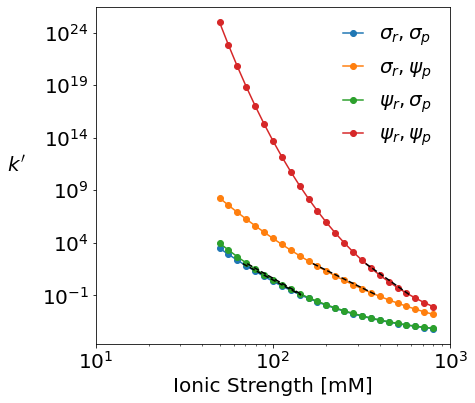

In [9]:
fig, ax = my_plot.instantiate_fig(xlabel='Ionic Strength [mM]',
                                 ylabel='$k\'$', rotation=0, ypad=25)
ax.set_xlim(10, 1000)

ax.loglog(is_vals_demo*1e3, kprime_vals_demo_charge, 'o-', label='$\sigma_r, \sigma_p$')
ax.loglog(is_vals_demo*1e3, kprime_vals_demo_res_charge_pro_pot, 'o-', label='$\sigma_r, \psi_p$')
ax.loglog(is_vals_demo*1e3, kprime_vals_demo_res_pot_pro_charge, 'o-', label='$\psi_r, \sigma_p$')
ax.loglog(is_vals_demo*1e3, kprime_vals_demo_pot, 'o-', label='$\psi_r, \psi_p$')

ax.loglog(np.array(is_vals_ch)*1e3, k_targets, '--', color='black')
ax.loglog(np.array(is_vals_pot)*1e3, k_targets, '--', color='black')
ax.loglog(np.array(is_vals_ch_pot)*1e3, k_targets, '--', color='black')
ax.loglog(np.array(is_vals_pot_ch)*1e3, k_targets, '--', color='black')

# ax.set_ylim(1e-2, 1e3)
my_plot.set_layout(fig, ax, legend=True, loc='upper right')

## Varying parameters

In [10]:
def corr_residual(log_ion_str, seq, surf_dens, pH, dpr, surf_area, porosity, kprime_target, res_bc_charge, res_bc_potential, pro_bc_charge, pro_bc_potential):
    ion_str = 10.0**log_ion_str
    sol = base_classes.solution(pH=pH, ion_str=ion_str)
    pro = hsu.protein(sol, seq=seq, dpr=dpr, bc_charge=pro_bc_charge, bc_potential=pro_bc_potential)    
    if pro.net_charge > 0:
        ligand = 'sulfonate'
    elif pro.net_charge < 0:
        ligand = 'quat_amine'
    else:
        assert False 
    res = hsu.resin(sol, ligand, surf_dens=surf_dens, dpr=dpr, bc_charge=res_bc_charge, bc_potential=res_bc_potential)
    
    kprime   = hsu.get_kprime(surf_area, porosity, pro, res)
    residual = np.log10(kprime) - np.log10(kprime_target)
    return residual

def corr_get_is_for_kprime(args):
    fit = optimize.least_squares(corr_residual, x0=[0], args=args, bounds=(-10, 10), ftol=1e-12, gtol=3e-16, xtol=3e-16)
    x0 = -2
    while abs(fit.fun[0]) > 1e-6:
        x0 -= 1
        fit = optimize.least_squares(corr_residual, x0=[x0], args=args, bounds=(-10, 10), ftol=1e-12, gtol=3e-16, xtol=3e-16)
        if x0 < -8:
            break
    assert fit.success
    assert fit.fun[0] < 1e-6 
    return 10.0**fit.x[0]

def run(args):
    p_id, seq, surf_dens, pH, res_bc_charge, res_bc_potential, pro_bc_charge, pro_bc_potential = args    
    dpr       = 2.0e-10 # minimum resting distance, m
    surf_area = 1.0e6   # accessible surface area, m-1, maybe use 1e7
    porosity  = 0.7     # accessible particle porosity

    sol = base_classes.solution(pH=7.0, ion_str=0.1)
    pro = hsu.protein(sol, seq=seq, dpr=dpr, bc_charge=True, bc_potential=False) 
    
    k_targets = [100, 0.1]
    is_vals =[]
    
    try:
        for k in k_targets:
            args = (seq, surf_dens, pH, dpr, surf_area, porosity, k, res_bc_charge, res_bc_potential, pro_bc_charge, pro_bc_potential)
            is_val = corr_get_is_for_kprime(args=args)
            is_vals.append(is_val)

        nu, phi_alpha = misc.get_nu_alpha(is_vals, k_targets)
        results = [p_id, pro.net_charge, nu, phi_alpha]
        return results
    except:
        pass

## Solutions with different boundary conditions

In [11]:
import warnings
warnings.simplefilter('ignore')

n = 100

In [12]:
for j in range(0, n):
    t0 = time.time()
    args_list = []
    for i in range(int(j*len(records)/n), int((j+1)*len(records)/n)):
        r = records[i]
        args_list.append((r.id, r.seq, 3.0e-6, 7.0, True, False, True, False))

    pool    = mp.Pool(processes = mp.cpu_count())
    results = pool.map(run, args_list)
    pool.close()
    pool.join()

    results = [k for k in results if k is not None]
    df_model = pd.DataFrame(results, columns=['id', 'charge', 'nu', 'phi_alpha'])
    df_model.to_csv(f'./mean_field_electrostatics/uniprot_hsu_rc_pc/{j}.csv', index=False)
    
    t = (time.time() - t0)/60
    print(f'{j}, {t:.2f} min')

0, 0.64 min
1, 0.62 min
2, 0.62 min
3, 0.74 min
4, 0.69 min
5, 0.73 min
6, 0.65 min
7, 0.66 min
8, 0.65 min
9, 0.67 min
10, 0.64 min
11, 0.64 min
12, 0.73 min
13, 0.68 min
14, 0.78 min
15, 0.64 min
16, 0.63 min
17, 0.65 min
18, 0.64 min
19, 0.68 min
20, 0.68 min
21, 0.65 min
22, 0.77 min
23, 0.74 min
24, 0.75 min
25, 0.68 min
26, 0.69 min
27, 0.68 min
28, 0.69 min
29, 0.64 min
30, 0.66 min
31, 0.68 min
32, 0.90 min
33, 0.66 min
34, 0.67 min
35, 0.71 min
36, 0.71 min
37, 0.67 min
38, 0.67 min
39, 0.73 min
40, 0.69 min
41, 0.65 min
42, 0.68 min
43, 0.73 min
44, 0.74 min
45, 0.66 min
46, 0.69 min
47, 0.70 min
48, 0.66 min
49, 0.74 min
50, 0.77 min
51, 0.69 min
52, 0.75 min
53, 0.69 min
54, 0.75 min
55, 0.69 min
56, 0.76 min
57, 0.95 min
58, 0.67 min
59, 0.66 min
60, 0.73 min
61, 0.73 min
62, 0.64 min
63, 0.66 min
64, 0.51 min
65, 0.48 min
66, 0.51 min
67, 0.51 min
68, 0.63 min
69, 0.72 min
70, 0.63 min
71, 0.75 min
72, 0.54 min
73, 0.54 min
74, 0.58 min
75, 0.65 min
76, 0.68 min
77, 0.67 

In [13]:
for j in range(0, n):
    t0 = time.time()
    args_list = []
    for i in range(int(j*len(records)/n), int((j+1)*len(records)/n)):
        r = records[i]
        args_list.append((r.id, r.seq, 3.0e-6, 7.0, True, False, False, True))

    pool    = mp.Pool(processes = mp.cpu_count())
    results = pool.map(run, args_list)
    pool.close()
    pool.join()

    results = [k for k in results if k is not None]
    df_model = pd.DataFrame(results, columns=['id', 'charge', 'nu', 'phi_alpha'])
    df_model.to_csv(f'./mean_field_electrostatics/uniprot_hsu_rc_pp/{j}.csv', index=False)
    
    t = (time.time() - t0)/60
    print(f'{j}, {t:.2f} min')

0, 0.45 min
1, 0.47 min
2, 0.46 min
3, 0.48 min
4, 0.46 min
5, 0.46 min
6, 0.47 min
7, 0.46 min
8, 0.45 min
9, 0.46 min
10, 0.45 min
11, 0.46 min
12, 0.46 min
13, 0.46 min
14, 0.44 min
15, 0.45 min
16, 0.47 min
17, 0.46 min
18, 0.46 min
19, 0.46 min
20, 0.47 min
21, 0.46 min
22, 0.46 min
23, 0.45 min
24, 0.45 min
25, 0.46 min
26, 0.47 min
27, 0.46 min
28, 0.46 min
29, 0.46 min
30, 0.45 min
31, 0.47 min
32, 0.46 min
33, 0.46 min
34, 0.45 min
35, 0.46 min
36, 0.46 min
37, 0.46 min
38, 0.46 min
39, 0.45 min
40, 0.45 min
41, 0.45 min
42, 0.46 min
43, 0.46 min
44, 0.45 min
45, 0.47 min
46, 0.45 min
47, 0.46 min
48, 0.45 min
49, 0.46 min
50, 0.46 min
51, 0.46 min
52, 0.46 min
53, 0.46 min
54, 0.46 min
55, 0.44 min
56, 0.45 min
57, 0.47 min
58, 0.46 min
59, 0.47 min
60, 0.46 min
61, 0.45 min
62, 0.46 min
63, 0.46 min
64, 0.42 min
65, 0.41 min
66, 0.42 min
67, 0.44 min
68, 0.44 min
69, 0.44 min
70, 0.45 min
71, 0.44 min
72, 0.43 min
73, 0.43 min
74, 0.42 min
75, 0.44 min
76, 0.45 min
77, 0.47 

In [14]:
for j in range(0, n):
    t0 = time.time()
    args_list = []
    for i in range(int(j*len(records)/n), int((j+1)*len(records)/n)):
        r = records[i]
        args_list.append((r.id, r.seq, 3.0e-6, 7.0, False, True, True, False))

    pool    = mp.Pool(processes = mp.cpu_count())
    results = pool.map(run, args_list)
    pool.close()
    pool.join()

    results = [k for k in results if k is not None]
    df_model = pd.DataFrame(results, columns=['id', 'charge', 'nu', 'phi_alpha'])
    df_model.to_csv(f'./mean_field_electrostatics/uniprot_hsu_rp_pc/{j}.csv', index=False)
    
    t = (time.time() - t0)/60
    print(f'{j}, {t:.2f} min')

0, 0.71 min
1, 0.69 min
2, 0.68 min
3, 0.78 min
4, 0.74 min
5, 0.77 min
6, 0.69 min
7, 0.69 min
8, 0.68 min
9, 0.69 min
10, 0.66 min
11, 0.65 min
12, 0.75 min
13, 0.69 min
14, 0.79 min
15, 0.66 min
16, 0.64 min
17, 0.67 min
18, 0.65 min
19, 0.69 min
20, 0.70 min
21, 0.65 min
22, 0.79 min
23, 0.74 min
24, 0.77 min
25, 0.68 min
26, 0.69 min
27, 0.68 min
28, 0.69 min
29, 0.63 min
30, 0.65 min
31, 0.68 min
32, 0.89 min
33, 0.66 min
34, 0.66 min
35, 0.71 min
36, 0.71 min
37, 0.67 min
38, 0.67 min
39, 0.73 min
40, 0.69 min
41, 0.65 min
42, 0.66 min
43, 0.71 min
44, 0.73 min
45, 0.65 min
46, 0.68 min
47, 0.71 min
48, 0.65 min
49, 0.74 min
50, 0.78 min
51, 0.68 min
52, 0.72 min
53, 0.69 min
54, 0.74 min
55, 0.68 min
56, 0.69 min
57, 0.95 min
58, 0.67 min
59, 0.65 min
60, 0.74 min
61, 0.74 min
62, 0.65 min
63, 0.67 min
64, 0.52 min
65, 0.48 min
66, 0.52 min
67, 0.51 min
68, 0.65 min
69, 0.71 min
70, 0.62 min
71, 0.76 min
72, 0.54 min
73, 0.53 min
74, 0.58 min
75, 0.65 min
76, 0.68 min
77, 0.66 

In [15]:
for j in range(0, n):
    t0 = time.time()
    args_list = []
    for i in range(int(j*len(records)/n), int((j+1)*len(records)/n)):
        r = records[i]
        args_list.append((r.id, r.seq, 3.0e-6, 7.0, False, True, False, True))

    pool    = mp.Pool(processes = mp.cpu_count())
    results = pool.map(run, args_list)
    pool.close()
    pool.join()

    results = [k for k in results if k is not None]
    df_model = pd.DataFrame(results, columns=['id', 'charge', 'nu', 'phi_alpha'])
    df_model.to_csv(f'./mean_field_electrostatics/uniprot_hsu_rp_pp/{j}.csv', index=False)
    
    t = (time.time() - t0)/60
    print(f'{j}, {t:.2f} min')

0, 0.46 min
1, 0.47 min
2, 0.46 min
3, 0.47 min
4, 0.46 min
5, 0.47 min
6, 0.48 min
7, 0.46 min
8, 0.46 min
9, 0.46 min
10, 0.46 min
11, 0.46 min
12, 0.47 min
13, 0.47 min
14, 0.46 min
15, 0.46 min
16, 0.47 min
17, 0.46 min
18, 0.46 min
19, 0.47 min
20, 0.47 min
21, 0.47 min
22, 0.47 min
23, 0.47 min
24, 0.46 min
25, 0.46 min
26, 0.48 min
27, 0.47 min
28, 0.47 min
29, 0.46 min
30, 0.47 min
31, 0.48 min
32, 0.48 min
33, 0.47 min
34, 0.46 min
35, 0.46 min
36, 0.46 min
37, 0.47 min
38, 0.47 min
39, 0.46 min
40, 0.46 min
41, 0.45 min
42, 0.46 min
43, 0.47 min
44, 0.46 min
45, 0.47 min
46, 0.45 min
47, 0.47 min
48, 0.45 min
49, 0.46 min
50, 0.47 min
51, 0.46 min
52, 0.47 min
53, 0.46 min
54, 0.47 min
55, 0.45 min
56, 0.46 min
57, 0.47 min
58, 0.48 min
59, 0.47 min
60, 0.47 min
61, 0.46 min
62, 0.47 min
63, 0.47 min
64, 0.42 min
65, 0.41 min
66, 0.41 min
67, 0.44 min
68, 0.44 min
69, 0.46 min
70, 0.46 min
71, 0.44 min
72, 0.42 min
73, 0.42 min
74, 0.43 min
75, 0.45 min
76, 0.46 min
77, 0.47 

# Comparison with lit. SDM parameters

## Combining separate .csv files 

And looking at data

In [6]:
directory = './mean_field_electrostatics/'
folders = [f for f in os.listdir(directory) if 'uniprot_hsu' in f]
folders.sort()

In [5]:
for folder in folders:
    files = os.listdir(directory + folder)
    files = [f for f in files if ('consolidated' not in f) and ('clean' not in f)]
    files.sort()
    
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(directory + folder + '/' + file)
        else:
            df_temp = pd.read_csv(directory + folder + '/' + file)
            df = pd.concat((df, df_temp))
    
    df.to_csv(directory + folder + '/consolidated.csv', index=False)

In [18]:
for folder in folders:
    df = pd.read_csv(directory + folder + '/consolidated.csv')
    df_temp = df[(abs(df.nu) != np.inf) & (abs(df.phi_alpha) != np.inf)]
    
    # Checks
    print(folder)
    print(len(set(df_temp.id)) - len(df_temp))
    df_bad_solution = df_temp[(df.nu < 0) | (df.phi_alpha < 0)]
    print(len(df_bad_solution))
    
    df_clean = df_temp[(df.nu >= 0) & (df.phi_alpha >= 0)]
    df_temp.to_csv(directory + folder + '/clean.csv', index=False)

uniprot_hsu_rc_pc
0
0
uniprot_hsu_rc_pp
0
0
uniprot_hsu_rp_pc
0
0
uniprot_hsu_rp_pp
0
0


In [19]:
n = 100
for j in range(n):
    for i in range(int(j*len(records)/n), int((j+1)*len(records)/n)):
        pass
    
max_num = i
max_num

562880

In [20]:
for folder in folders:
    df = pd.read_csv(directory + folder + '/clean.csv')
    print(folder)
    print(f'{len(df)}, {len(df)/max_num*100:.2f}%')

uniprot_hsu_rc_pc
547464, 97.26%
uniprot_hsu_rc_pp
562879, 100.00%
uniprot_hsu_rp_pc
547452, 97.26%
uniprot_hsu_rp_pp
562879, 100.00%


## Comparison

In [7]:
def my_fit_function_ln_keq_2(tis, a, b):
    return np.log(a*tis**b)

def meta_correlation(a, c, d):
    return c*np.log(a) + d

def get_meta_residuals(x, a_vals, b_vals):
    c = x[0]
    d = x[1]
    return b_vals - (c*np.log(a_vals) + d)

def get_reg_intervals(x, y, alpha=0.05, line_extension=0.0):
    slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment
    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(1.0-alpha/2.0, dof) # Students statistic of interval confidence

    residual = y - y_model
    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # mean squared error
    MSE = 1/n * np.sum( residual**2 )

    # to plot the adjusted model
    x_line = np.linspace(np.min(x)-line_extension, np.max(x)+line_extension, 1000)
    y_line = np.polyval([slope, intercept], x_line)

    # intervals
    ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
    pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  
    pred_err_var = (std_error**2.0) * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))
    
    return x_line, y_line, ci, pi, pred_err_var

def get_pred_err_var(x, y, x_star):
    slope, intercept = np.polyfit(x, y, 1)  
    y_model = np.polyval([slope, intercept], x)  
    residual = y - y_model

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                       
    m = 2                            
    dof = n - m   
    
    pred_err_var = (np.sum(residual**2) / dof) * (1 + 1/n + (x_star - x_mean)**2 / np.sum((x - x_mean)**2))
    return pred_err_var
    
def plot_intervals(x, y, x_line, y_line, ci, pi):
    fig, ax = my_plot.instantiate_fig()
    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_xscale('log')
    
    color = 'blue'
    ax.plot(np.exp(x), y, 'o', color = 'royalblue')
    ax.plot(np.exp(x_line), y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
#     ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse(x, y, x_line, y_line, ci, pi):
    fig, ax = my_plot.instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$a$')
    ax.set_yscale('log')
    
    color = 'blue'
    ax.plot(x, np.exp(y), 'o', color = 'royalblue')
    ax.plot(x_line, np.exp(y_line), color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, np.exp(y_line + pi), np.exp(y_line - pi), color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, np.exp(y_line + ci), np.exp(y_line - ci), color = 'skyblue', label = '95% CI')
    ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse_ln(x, y, x_line, y_line, ci, pi):
    fig, ax = my_plot.instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$ln(a)$')
    
    color = 'blue'
    ax.plot(x, y, 'o', color = 'royalblue')
    ax.plot(x_line, y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
    ax.legend(loc='lower left', fontsize=16)

    return fig, ax

In [8]:
# Load data
df_all_k = pd.read_csv('./lit_data/all_kprime.csv')
df_all_k.fillna(0.0, inplace=True)

df_2_fit_parms = pd.read_csv('./lit_data/two_params_all_data.csv')
resins = list(set(df_2_fit_parms.resin))
resins.sort()

df_2_fit_parms['ln_a'] = np.log(df_2_fit_parms.a)
data = np.zeros((len(df_2_fit_parms), 2))
data[:,0] = df_2_fit_parms.ln_a
data[:,1] = df_2_fit_parms.b

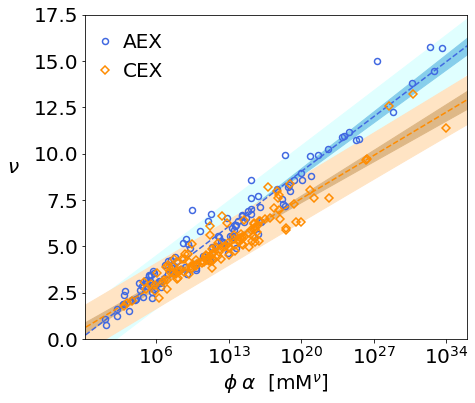

In [10]:
def plot_lit_data():
    fig, ax = my_plot.instantiate_fig()
    ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
    ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

    ax.set_xscale('log')
    # Normal lim
    ax.set_xlim(np.exp(-2), np.exp(83))
    ax.set_ylim(0, 17.5)
    ## Larger lim
#     ax.set_xlim(np.exp(-20), 1.0e55)
#     ax.set_ylim(0, 30)

    iex_type_list = ['aex', 'cex']
    for iex_type in iex_type_list:
        df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

        data = np.zeros((len(df), 2))
        data[:,0] = df.ln_a
        data[:,1] = -1*df.b

        x = data[:,0]
        y = data[:,1]

        x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)

        if iex_type == 'aex':
            color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
            marker, fillstyle = 'o', 'full'
        elif iex_type == 'cex':
            color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
            marker, fillstyle = 'D', 'full'

        ax.plot(np.exp(x), y, marker=marker, fillstyle='none', markeredgewidth=1.5, linewidth=0, color=color_1, label=iex_type.upper())
        ax.plot(np.exp(x_line), y_line, color=color_1, linestyle='--')
        ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color=color_3)
        ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color=color_2)

    my_plot.set_layout(fig, ax)
    return fig, ax


fig, ax = plot_lit_data()
ax.legend(loc='upper left', handlelength=0.2, frameon=False)

# fig.savefig(f'./images/mean_field_electrostatics/lit_data.png', dpi=300)

In [13]:
folders

['uniprot_hsu_rc_pc',
 'uniprot_hsu_rc_pp',
 'uniprot_hsu_rp_pc',
 'uniprot_hsu_rp_pp']

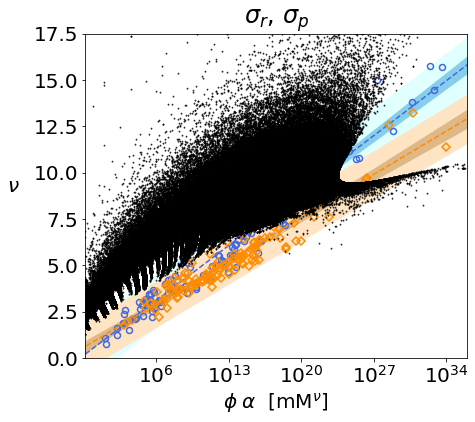

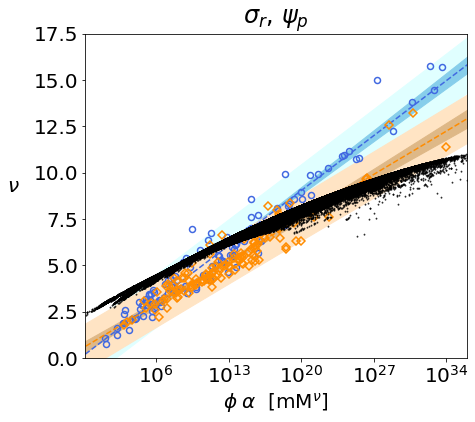

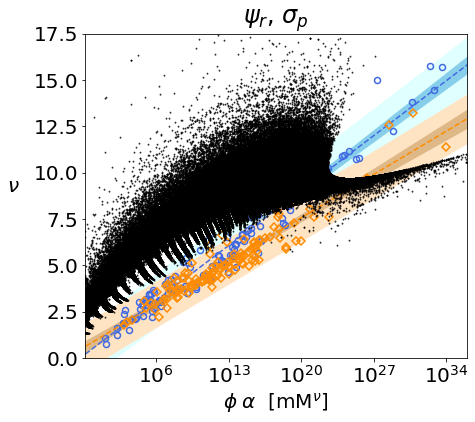

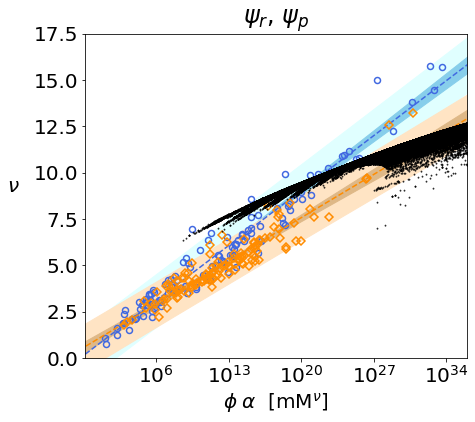

In [11]:
for folder in folders:
    df = pd.read_csv(directory + folder + '/clean.csv')
    fig, ax = plot_lit_data()
    ax.plot(df.phi_alpha, df.nu, '^', color='black', fillstyle='none', markersize=1)
    
    if '_rc_' in folder:
        l1 = '$\sigma_r$'
    else:
        l1 = '$\psi_r$'
        
    if '_pc' in folder:
        l2 = '$\sigma_p$'
    else:
        l2 = '$\psi_p$'
    
    title = f'{l1}, {l2}'
    plt.title(title)
#     fig.savefig(f'./images/mean_field_electrostatics/lit_data_vs_{folder[-9:]}.png', dpi=300)

In [14]:
def plot_lit_data_subfigure(ax):
    ax.set_xscale('log')
    # Normal lim
    ax.set_xlim(np.exp(-2), np.exp(83))
    ax.set_ylim(0, 17.5)
    ## Larger lim
#     ax.set_xlim(np.exp(-20), 1.0e55)
#     ax.set_ylim(0, 30)

    iex_type_list = ['aex', 'cex']
    for iex_type in iex_type_list:
        df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

        data = np.zeros((len(df), 2))
        data[:,0] = df.ln_a
        data[:,1] = -1*df.b

        x = data[:,0]
        y = data[:,1]

        x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)

        if iex_type == 'aex':
            color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
            marker, fillstyle = 'o', 'full'
        elif iex_type == 'cex':
            color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
            marker, fillstyle = 'D', 'full'

        ax.plot(np.exp(x), y, marker=marker, fillstyle='none', markeredgewidth=1.5, linewidth=0, color=color_1, label=iex_type.upper())
        ax.plot(np.exp(x_line), y_line, color=color_1, linestyle='--')
        ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color=color_3)
        ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color=color_2)

    return ax

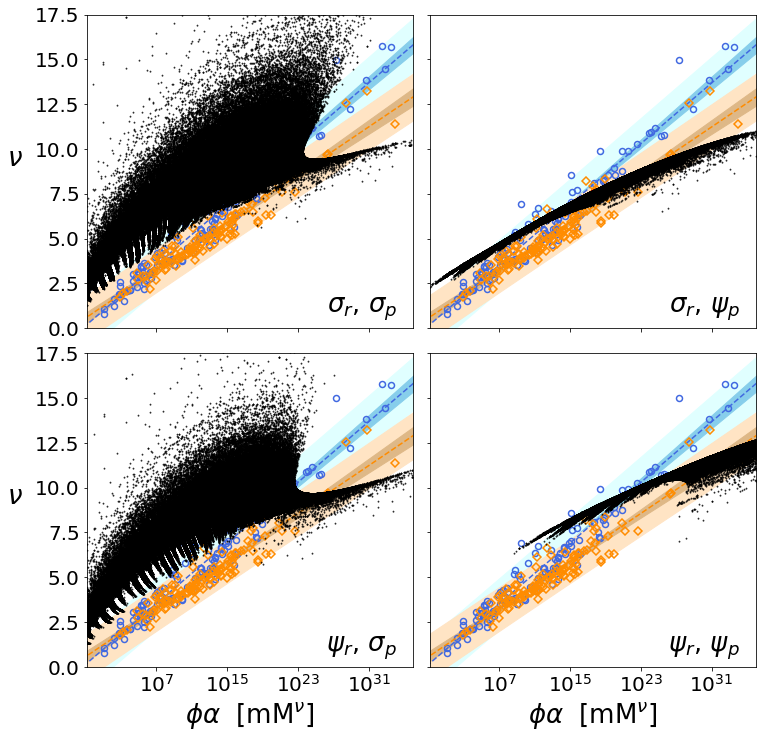

In [23]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
plt.subplots_adjust(wspace=0.05, hspace=0.08)

for i in range(2):
    ax[1, i].set_xlabel(r'$\phi \alpha$  [mM$^\nu$]', fontsize=26)
    ax[i, 0].set_ylabel(r'$\nu$', rotation=0, labelpad=20, fontsize=26)
    
for i, folder in enumerate(folders):
    df = pd.read_csv(directory + folder + '/clean.csv')
    if i < 2: 
        v1 = 0
        v2 = i
    else:
        v1 = 1
        v2 = i - 2
        
    ax[v1, v2] = plot_lit_data_subfigure(ax[v1, v2])
    ax[v1, v2].plot(df.phi_alpha, df.nu, '^', color='black', fillstyle='none', markersize=1)
    
    if '_rc_' in folder:
        l1 = '$\sigma_r$'
    else:
        l1 = '$\psi_r$'
        
    if '_pc' in folder:
        l2 = '$\sigma_p$'
    else:
        l2 = '$\psi_p$'
        
    ax[v1, v2].text(0.95, 0.05, f'{l1}, {l2}', horizontalalignment='right', transform=ax[v1, v2].transAxes, fontsize=26)
    
fig.savefig(f'./images/mean_field_electrostatics/lit_data_vs_hsu_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(f'./images/mean_field_electrostatics/lit_data_vs_hsu_all.pdf', bbox_inches='tight')